# Helpers

In [1]:
import itertools
import json
import pandas as pd
import random
import numpy as np
import random
import matplotlib.pyplot as plt

from vowpalwabbit import pyvw

class environment:
    def __init__(self, means):
        self.means = means
        self.nsteps = self.means.shape[0]
        self.npeople = self.means.shape[1]
        self.narms = self.means.shape[2]

        self.arms = [f'|a a_{a}' for a in range(self.narms)]
        self.people = []
        for s in range(self.nsteps):
            self.people.append([f'shared |s p_{s}_{p}' for p in range(self.npeople)])

    def generate(self, cmd, count):
        result=[]
        vw = pyvw.vw(cmd)
        for i in range(count):
            p = random.randint(0, self.npeople-1)
            step = i % self.nsteps
            row = {'s': step, 'p': p}

            pred = vw.predict([vw.example(e) for e in self.get_pred_ex(step, p)])
            pred = np.divide(pred, np.sum(pred))
            c = np.random.choice(self.narms, p=pred)

            r = int(random.uniform(0,1)<self.means[step][p][c])
            vw.learn([vw.example(e) for e in self.get_learn_ex(step, p, c, pred[c], r)])
            row[f'chosen']=c
            row[f'online']=pred[c]
            row[f'r']=r
            result.append(row)
        return result

    def get_pred_ex(self, step, person, suffix=None):
        if suffix:
            return [self.people[step][person] + f' {suffix}'] + self.arms
        return [self.people[step][person]] + self.arms      

    def get_learn_ex(self, step, person, action, prob, reward, suffix=None):
        label=f'{action}:{-reward}:{prob}'
        result = self.get_pred_ex(step, person, suffix)
        result[action + 1] = f'{label} {result[action + 1]}'
        return result


class steps_gen:
    def __init__(self, steps):
        self.steps = steps
        self.i = 0

    def get(self):
        self.i = (self.i + 1) % len(self.steps)
        return self.steps[self.i]

def cfe(cmd, scenario, env, get_steps, reward_f, name, with_episode_length):
    from vowpalwabbit import pyvw
    result = []
    vw = pyvw.vw(cmd)
    remains = get_steps.get()
    suffix = f'e_{remains}' if with_episode_length else None
    episode = []
    patched=[]
    for l in scenario:
        episode.append(l)
        remains = remains - 1
        if remains == 0:
            rewards = []

            for step in episode:
                ex_pred_str = env.get_pred_ex(step['s'], step['p'])
                ex_pred = [vw.example(e) for e in ex_pred_str]
                pred=vw.predict(ex_pred)
                result.append(pred[step['chosen']])
                rewards.append(step['r'])

            reward = reward_f(rewards)
            for i in range(len(episode)):
                ex_learn_str = env.get_learn_ex(episode[i]['s'], episode[i]['p'], episode[i]['chosen'], episode[i]['online'], reward)
                ex_learn = [vw.example(e) for e in ex_learn_str]
                vw.learn(ex_learn)
            
            episode=[]
            remains=get_steps.get()
            suffix = f'e_{remains}' if with_episode_length else ''
    return pd.DataFrame({name: result})

def plot_top_action_prob(df, means, prob_columns=['online']):
    best = []
    for i, step in enumerate(means):
        best = best + [{'s': i, 'p': p, 'best': best} for p, best in enumerate(np.argmax(step, axis=1))]
    best = pd.DataFrame(best)
    details = pd.merge(df, best, on=['s', 'p'], how='left')
    for prob_column in prob_columns:
        for i in range(means.shape[0]):
            for j in range(means.shape[1]):
                details[(details['s']==i) & (details['p']==j) & (details['chosen']==details['best'])][prob_column].expanding().mean().plot(label=f'{prob_column}/{i}/{j}', logx=True, figsize=(10,6)) 
    plt.legend() 

def plot(results, policies):
    for p in policies:
        ((results['r'] * results[p]) / results['online']).expanding().mean().plot(logx=True, figsize=(12,8), label=p)
    plt.legend()

def join(online, cfes: list):
    result = online
    for cfe in cfes:
        result = result.join(cfe)
    return result

# Setup arms configuration (8 people, 8 actions)

In [2]:
npeople = 8
narms = 8

means_8_8 = np.random.rand(1,npeople, narms)
env_8_8 = environment(means_8_8)
print(f'Random perfomance: {np.mean(env_8_8.means)}')
print(f'Best performance: {np.max(env_8_8.means, axis=2).mean()}')
print(f'Best performance with 0.2 exploration: {np.max(env_8_8.means, axis=2).mean() * 0.8 + 0.2 * np.mean(env_8_8.means)}')

Random perfomance: 0.5549823163766952
Best performance: 0.9210616588133741
Best performance with 0.2 exploration: 0.8478457903260384


# Generate some data

In [3]:
vw_args='--cb_explore_adf --dsjson --epsilon 0.2 --coin --power_t 0 --quiet --cb_type mtr --ignore_linear s -q sa --noconstant'

events_8_8 = env_8_8.generate(vw_args, 1024 * 128)
events_8_8_df=pd.DataFrame(events_8_8)
events_8_8_df.head()

,s,p,chosen,online,r
0,0,3,7,0.125,1
1,0,1,0,0.125,1
2,0,4,0,0.125,1
3,0,6,0,0.825,0
4,0,5,0,0.825,1


# Double check that we've learned everything

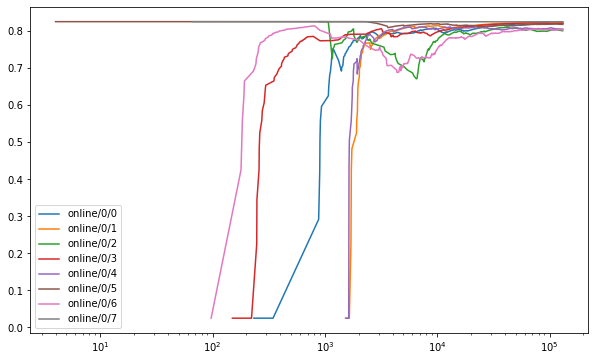

In [4]:
plot_top_action_prob(events_8_8_df, env_8_8.means)

r_mean = 0.831756591796875


<AxesSubplot:>

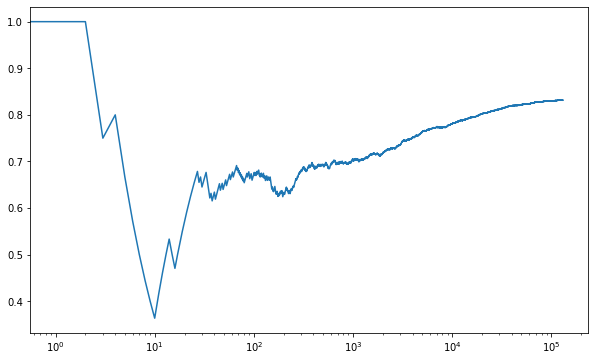

In [5]:
print(f'r_mean = {events_8_8_df["r"].mean()}')
events_8_8_df['r'].expanding().mean().plot(figsize=(10,6), logx=True)

# CFE

In [ ]:
vw_args_cfe='--cb_explore_adf --dsjson --epsilon 0 --coin --power_t 0 --quiet --cb_type mtr --ignore_linear s -q sa --noconstant'

In [ ]:
step1_8_8 = cfe(vw_args_cfe, events_8_8, env_8_8, steps_gen([1]), np.mean, '1-step', with_episode_length=False)

In [ ]:
step2mean_8_8 = cfe(vw_args_cfe, events_8_8, env_8_8, steps_gen([2]), np.mean, '2-step.mean', with_episode_length=False)
step4mean_8_8 = cfe(vw_args_cfe, events_8_8, env_8_8, steps_gen([4]), np.mean, '4-step.mean', with_episode_length=False)
step8mean_8_8 = cfe(vw_args_cfe, events_8_8, env_8_8, steps_gen([8]), np.mean, '8-step.mean', with_episode_length=False)

In [ ]:
step2sum_8_8 = cfe(vw_args_cfe, events_8_8, env_8_8, steps_gen([2]), np.sum, '2-step.sum', with_episode_length=False)
step4sum_8_8 = cfe(vw_args_cfe, events_8_8, env_8_8, steps_gen([4]), np.sum, '4-step.sum', with_episode_length=False)
step8sum_8_8 = cfe(vw_args_cfe, events_8_8, env_8_8, steps_gen([8]), np.sum, '8-step.sum', with_episode_length=False)

In [ ]:
step2max_8_8 = cfe(vw_args_cfe, events_8_8, env_8_8, steps_gen([2]), np.max, '2-step.max', with_episode_length=False)
step4max_8_8 = cfe(vw_args_cfe, events_8_8, env_8_8, steps_gen([4]), np.max, '4-step.max', with_episode_length=False)
step8max_8_8 = cfe(vw_args_cfe, events_8_8, env_8_8, steps_gen([8]), np.max, '8-step.max', with_episode_length=False)

# Look at results

In [ ]:
result_8_8 = join(events_8_8_df, 
    [
        step1_8_8,
        step2mean_8_8,
        step4mean_8_8,
        step8mean_8_8,
        step2sum_8_8,
        step4sum_8_8,
        step8sum_8_8, 
        step2max_8_8,
        step4max_8_8,
        step8max_8_8,               
    ])

In [ ]:
plot(result_8_8, ['1-step', '2-step.mean', '4-step.mean', '8-step.mean'])

In [ ]:
plot(result_8_8, ['1-step', '2-step.sum', '4-step.sum', '8-step.sum'])

In [ ]:
plot(result_8_8, ['1-step', '2-step.max', '4-step.max', '8-step.max'])

# Setup arms configuration (2 steps, 4 people, 8 actions)

In [ ]:
npeople = 4
narms = 8

#means_2_4_8 = np.random.rand(2,npeople, narms)
means_2_4_8 = env_8_8.means.reshape((2,4,8))
env_2_4_8 = environment(means_2_4_8)
print(f'Random perfomance: {np.mean(env_2_4_8.means)}')
print(f'Best performance: {np.max(env_2_4_8.means, axis=2).mean()}')
print(f'Best performance with 0.2 exploration: {np.max(env_2_4_8.means, axis=2).mean() * 0.8 + 0.2 * np.mean(env_2_4_8.means)}')

In [ ]:
vw_args='--cb_explore_adf --dsjson --epsilon 0.2 --coin --power_t 0 --quiet --cb_type mtr --ignore_linear s -q sa --noconstant'

events_2_4_8 = env_2_4_8.generate(vw_args, 1024 * 128)
events_2_4_8_df=pd.DataFrame(events_2_4_8)
events_2_4_8_df.head()

In [ ]:
plot_top_action_prob(events_2_4_8_df, env_2_4_8.means)

In [ ]:
print(f'r_mean = {events_2_4_8_df["r"].mean()}')
events_2_4_8_df['r'].expanding().mean().plot(figsize=(10,6), logx=True)

In [ ]:
vw_args_cfe='--cb_explore_adf --dsjson --epsilon 0 --coin --power_t 0 --quiet --cb_type mtr --ignore_linear s -q sa --noconstant'

In [ ]:
step1_2_4_8 = cfe(vw_args_cfe, events_2_4_8, env_2_4_8, steps_gen([1]), np.mean, '[2] 1-step', with_episode_length=False)

In [ ]:
step2mean_2_4_8 = cfe(vw_args_cfe, events_2_4_8, env_2_4_8, steps_gen([2]), np.mean, '[2] 2-step.mean', with_episode_length=False)
step4mean_2_4_8 = cfe(vw_args_cfe, events_2_4_8, env_2_4_8, steps_gen([4]), np.mean, '[2] 4-step.mean', with_episode_length=False)
step8mean_2_4_8 = cfe(vw_args_cfe, events_2_4_8, env_2_4_8, steps_gen([8]), np.mean, '[2] 8-step.mean', with_episode_length=False)

In [ ]:
step2sum_2_4_8 = cfe(vw_args_cfe, events_2_4_8, env_2_4_8, steps_gen([2]), np.sum, '[2] 2-step.sum', with_episode_length=False)
step4sum_2_4_8 = cfe(vw_args_cfe, events_2_4_8, env_2_4_8, steps_gen([4]), np.sum, '[2] 4-step.sum', with_episode_length=False)
step8sum_2_4_8 = cfe(vw_args_cfe, events_2_4_8, env_2_4_8, steps_gen([8]), np.sum, '[2] 8-step.sum', with_episode_length=False)

# Look at results

In [ ]:
result_2_4_8 = join(events_2_4_8_df, 
    [
        step1_2_4_8,
        step2mean_2_4_8,
        step4mean_2_4_8,
        step8mean_2_4_8,
        step2sum_2_4_8,
        step4sum_2_4_8,
        step8sum_2_4_8, 
 #       step2max_2_4_8,
 #       step4max_2_4_8,
 #       step8max_2_4_8,               
    ])

In [ ]:
plot(result_2_4_8, ['[2] 1-step', '[2] 2-step.mean', '[2] 4-step.mean', '[2] 8-step.mean'])

In [ ]:
plot(result_2_4_8, ['[2] 1-step', '[2] 2-step.sum', '[2] 4-step.sum', '[2] 8-step.sum'])

In [ ]:
plot(result_8_8, ['1-step', '2-step.sum'])
plot(result_2_4_8, ['[2] 1-step', '[2] 2-step.sum'])

In [ ]:
plot(result_8_8, ['1-step', '2-step.mean'])
plot(result_2_4_8, ['[2] 1-step', '[2] 2-step.mean'])